In [1]:
# Library
import os
import numpy as np
from numpy.random import randint
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.metrics import Precision
from keras.callbacks import LearningRateScheduler
from keras.layers import Flatten, Dropout, Dense, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.applications import MobileNetV2, DenseNet121, vgg19
# Set path
%cd C:\Users\user\Desktop\KUL - Mstat\Big Data Platforms and Technologies\project2

C:\Users\user\Desktop\KUL - Mstat\Big Data Platforms and Technologies\project2


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

**<font color='blue'>The second part of your lab report should contain:</font>**
- <font color='blue'>Overview of your full deep learning pipe line, including architecture, trade-offs, ways used to prevent overfitting</font>
- <font color='blue'>Results based on your chosen evaluation metric</font>
- <font color='blue'>Illustration of your model's predictions on a test image (or one of your own)</font>
- <font color='blue'>Style points if you test out your model on a picture of your own (e.g. using FastAPI / Shiny / Flask / …)</font>
- <font color='blue'>Style points if you apply some interpretability techniques</font>
- <font color='blue'>You don’t need a beefy machine / GPU! Downscale images, use transfer learning with a pretrained model / image augmentation, ...</font>

In [3]:
# Read guideline
receipes = pd.read_csv(os.getcwd() + r'\\recipes.csv', sep = ';')
# Read tag
tag = pd.read_table(os.getcwd() + r'\\tag_merge.txt', sep = ',', header = None, skipinitialspace=True)

In [4]:
receipes.head(3)

,photo_id,url,may_be,likes,timestamp,scraped_at,diff,tag_healthy,tag_tasty,tag_dinner,tag_vegan,tag_breakfast,tag_lunch,tag_dessert,tag_baking,tag_cake,tag_easyrecipes,tag_chocolate,tag_vegetarian,tag_sweet,tag_pasta,tag_diet,tag_fitness,tag_glutenfree,tag_chicken,tag_weightloss,tag_veganfood,tag_plantbased,tag_cheese,tag_italianfood,tag_salad,tag_keto,tag_pastry,tag_fresh,tag_snack,tag_cookies,tag_comfortfood,tag_lowcarb,tag_protein,tag_bread,tag_indianfood,tag_vegetables,tag_pizza,tag_coffee,tag_bake,tag_desserts,tag_sweets,tag_soup,tag_organic,tag_easy,tag_bakery,tag_fruit,tag_veggies,tag_meat,tag_rice,tag_fish,tag_eggs,tag_breakfastideas,tag_italy,tag_brunch,tag_veggie,tag_vegetarianrecipes,tag_pancakes,tag_seafood,tag_baker,tag_veganrecipe,tag_dairyfree,tag_sweettooth,tag_ketodiet,tag_lemon,tag_cheesecake,tag_snacks,tag_ilovefood,tag_food52,tag_foodbloggers,tag_family,tag_avocado,tag_cakes,tag_curry,tag_banana,tag_gastronomy,tag_chocolat,tag_oats,tag_bbq,tag_italia,tag_pastalover,tag_icecream,tag_spicy,tag_smoothie,tag_asianfood,tag_garlic,tag_streetfood,tag_travel,tag_salmon,tag_egg,tag_oatmeal,tag_natural,tag_beef,tag_noodles,tag_italian,tag_drinks,tag_steak,tag_sandwich,tag_strawberry
0,CMPELQqh_nh,https://www.instagram.com/p/CMPELQqh_nh/,dessert and indoor,3,2021-03-10T10:47:18,2021-03-10T11:48:52,1.03,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CMPEHqppR-t,https://www.instagram.com/p/CMPEHqppR-t/,pasta and indoor,3,2021-03-10T10:46:48,2021-03-10T11:48:59,1.04,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CMPEBY9Buko,https://www.instagram.com/p/CMPEBY9Buko/,cake and indoor,2,2021-03-10T10:45:57,2021-03-10T11:49:08,1.05,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# Transform tag's into a dictionary {'old tag': 'new tag'}
newheader = tag[0]
tag_dict = tag.T.iloc[[1]]
tag_dict.columns = newheader.values
tag_dict = tag_dict.T.to_dict()[1]

In [6]:
len(tag_dict)

50

<font color='red'>There seems to be too many labels...</font>

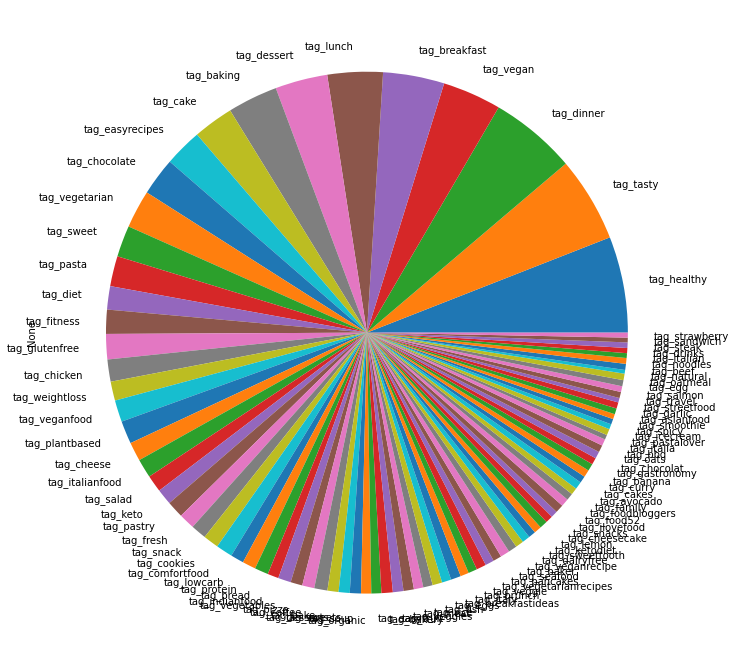

In [7]:
# Class distribution
column_tag = receipes.columns.to_series().str.startswith('tag_')
column_tag = receipes.columns[column_tag]
receipes[column_tag].sum().plot.pie(figsize = (12, 12))

<font color='red'>Image processing </font>

In [8]:
# Load data
def load_data(IMGSIZE):
    images, labels = list(), list()
    nonempty = receipes[column_tag].sum(axis = 1) > 0
    for ind, photo_id in enumerate(receipes['photo_id']):
        # In case of empty image, load_img() gives warnings, use try except here
        try:
            if nonempty[ind] :
                IMGPATH = r'\recipes\recipes' + '\\' + photo_id + '.png'
                image = load_img(os.getcwd() + IMGPATH, target_size = IMGSIZE)
                label = receipes.iloc[ind][column_tag] == 1
                images.append(img_to_array(image))
                labels.append(column_tag[label])
        except: 
            continue
    return images, labels

In [9]:
%%time
# (224, 224) for 
# It may take a while to run
IMGSIZE = (224, 224)
X, y = load_data(IMGSIZE)

Wall time: 1min 37s


<font color='red'>Randomly show you some images</font>

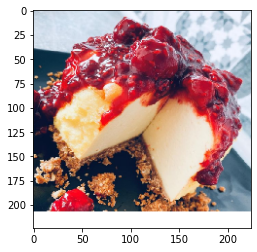

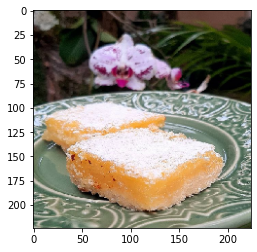

In [10]:
N = len(X)
rand_indices = randint(0, N, size = 2)
for ind in rand_indices:
    plt.imshow(array_to_img(X[ind]))
    plt.show()

<font color='red'>Too many labels, regroup them</font>

In [11]:
# Some tag are unrelated to types of food
drop_tag = ['tag_easyrecipes', 'tag_ilovefood', 'tag_food52', 'tag_foodbloggers', 'tag_family',
           'tag_glutenfree', 'tag_easy']

In [12]:
# Each element of yn contains a list of tags with nonzero values
def map_tag(tags):
    tag_merged = set()
    for tag in tags:
        if tag in tag_dict.keys():
            tag_merged.add(tag_dict[tag])
        elif tag not in drop_tag:
            tag_merged.add(tag)
    return list(tag_merged)
yn = [map_tag(tags) for tags in y]

In [13]:
# Update column names: Drop names appeared in drop_tag, group names tgt using tag_dict
new_labels = column_tag.drop(drop_tag).to_series().replace(tag_dict).values

In [14]:
# Convert each element of yn into an array using dictionary as mapping
def get_dict(tags):
    dict_temp = dict()
    for new_label, exist in zip(new_labels, [0] * len(new_labels)):
        if new_label in tags:
            exist = 1
        dict_temp[new_label] = exist
    return dict_temp
y_np = pd.DataFrame([get_dict(tags) for tags in yn])

<font color='red'>Too many tags, some tag has only few observations. Select the types of food which are most frequent</font>

In [15]:
chosen_labels = ['tag_healthy_concept', 'tag_sweet_concept', 'tag_bake_concept', 'tag_chocolate_concept', 
                 'tag_vegetarian_concept', 'tag_sweet', 'tag_pasta_concept', 'tag_italy_concept']
y_np = y_np[chosen_labels].to_numpy()

In [16]:
# Label for each class
y_np.sum(axis = 0)

array([1756, 1202, 1385,  592, 1357,  465,  534,  513], dtype=int64)

<font color='red'>Randomly sample some images given tag, some may look weird</font>

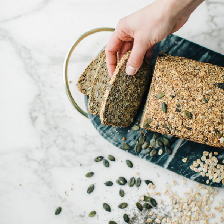

In [17]:
# Check some concepts
photo_id = receipes[receipes['tag_easy'] == 1].sample(1)['photo_id'].values[0]
IMGPATH = r'\recipes\recipes' + '\\' + photo_id + '.png'
load_img(os.getcwd() + IMGPATH, target_size = IMGSIZE)

In [18]:
# How many image belongs to such tag?
TAG = 'tag_easy'
receipes[receipes[TAG] == 1].shape[0]

148

--- 

<font color='red'> Rescaling & Train-test split</font>

In [19]:
%%time
# Rescaling input
X = np.array(X)

Wall time: 5.16 s


In [20]:
%%time 
# Train:Val:Test = 0.7:0.2:0.1
X_train, X_test, y_train, y_test = train_test_split(X, y_np, test_size = 0.1, random_state = 721)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.27, random_state = 831)

Wall time: 11.9 s


In [21]:
del X

<font color='red'>Transfer learning models</font>

In [22]:
# A model for dense net
def model_wrap(FREEZE, lr, input_shape, output_shape, drop_out_rate):
    model_pretrained_load = MobileNetV2(weights = 'imagenet', include_top = False, 
                             input_shape = input_shape)
    model_pretrained_load.trainable = FREEZE # Freeze the pretrained model
    for layer in model_pretrained_load.layers[-35:]:
        layer.trainable = True
    model = Sequential()
    model.add(model_pretrained_load) # Pretrained model
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(drop_out_rate))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(drop_out_rate))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(drop_out_rate))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(output_shape, activation = 'sigmoid'))
    # Compile model
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = lr),  
              metrics=['accuracy', Precision(), 'AUC'])
    return model

In [23]:
# Compile a model
input_shape =([224, 224, 3])
output_shape = 8
drop_out_rate = 0.3
model = model_wrap(False, 0.02, input_shape, output_shape, drop_out_rate)

<font color='red'>Data augmentation</font>

<font color='red'>Data augmentation on training data with parameters set in *aug_param*</font>

In [24]:
%%time
aug_param = {
    'featurewise_center': False,
    'featurewise_std_normalization': False,
    'rotation_range': 20,
    'vertical_flip': True,
    'zoom_range': 0.2,
    'rescale': 1./255}
train_gen = ImageDataGenerator(**aug_param).flow(np.concatenate((X_train, X_train)), 
                                                 np.concatenate((y_train, y_train)), 
                                                 batch_size = 16)

Wall time: 2.12 s


<font color='red'>Create a generator for validation data *without* data augmentation</font>

In [25]:
val_gen = ImageDataGenerator(rescale = 1./255).flow(X_val, y_val, batch_size = 16)

<font color='red'>Learning rate scheduler</font>

In [26]:
def decay_lr(epoch, lr):
    if epoch >= 2 and epoch < 6:
        lr = lr * 0.1
    return lr
callback = LearningRateScheduler(decay_lr)

In [27]:
%%time
train_param = {'generator': train_gen, 
               'validation_data': val_gen, 
               'validation_steps': len(y_val)/16,
               'workers': 10,
               'epochs': 20,
               'callbacks': [callback]}
history = model.fit_generator(**train_param)

C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
647/647 [==============================] - 193s 291ms/step - loss: 0.4225 - accuracy: 0.3514 - precision: 0.1714 - auc: 0.6149 - val_loss: 0.3636 - val_accuracy: 0.0956 - val_precision: 0.0000e+00 - val_auc: 0.6357
Epoch 2/20
647/647 [==============================] - 184s 284ms/step - loss: 0.3570 - accuracy: 0.4887 - precision: 0.3389 - auc: 0.6561 - val_loss: 0.3598 - val_accuracy: 0.5695 - val_precision: 0.0000e+00 - val_auc: 0.6378
Epoch 3/20
647/647 [==============================] - 184s 284ms/step - loss: 0.3584 - accuracy: 0.5500 - precision: 0.0000e+00 - auc: 0.6515 - val_loss: 0.3592 - val_accuracy: 0.5695 - val_precision: 0.0000e+00 - val_auc: 0.6387
Epoch 4/20
647/647 [==============================] - 184s 285ms/step - loss: 0.3621 - accuracy: 0.5309 - precision: 0.0000e+00 - auc: 0.6575 - val_loss: 0.3591 - val_accuracy: 0.5695 - val_precision: 0.0000e+00 - val_auc: 0.6396
Epoch 5/20
647/647 [==============================] - 183s 283ms/step - loss: 0.3582 - a

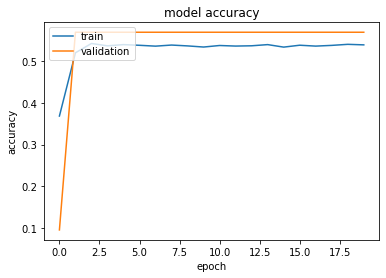

In [28]:
# Plot history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

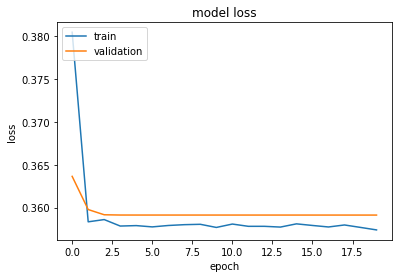

In [29]:
# Plot history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

---

In [30]:
# Save models
model.save('mobilenetv2_one.h5')

In [31]:
# Performance on tests
model.evaluate(X_test, y_test)

25/25 [==============================] - 12s 405ms/step - loss: 0.3497 - accuracy: 0.5812 - precision: 0.0000e+00 - auc: 0.6590


[0.3496779501438141, 0.5812183022499084, 0.0, 0.6589546203613281]